# Reconstruction using top eigen-vectors

## Load the required libraries

In [1]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('./lib')

import findspark
findspark.init()

from import_modules import import_modules,modules
import_modules(modules)


from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter

    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=None


In [4]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [9]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T # scaling to make the temperature be in centingrates
shape(T)

(13047, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

In [12]:
m='SNWD'

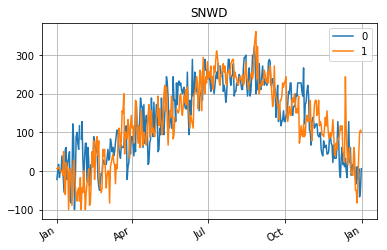

In [13]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

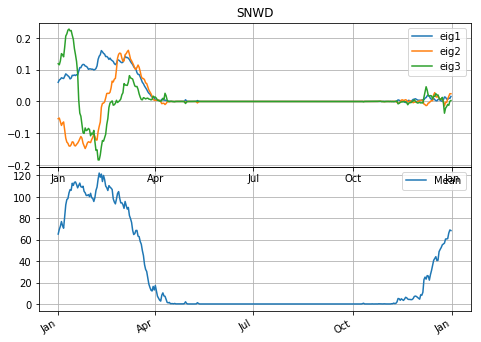

In [14]:
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
fig=plt.figure(figsize=(6,4))
ax=fig.add_axes([0,0,1,.5])
YearPlotter().plot(Mean,fig,ax,label='Mean',title=m)
ax=fig.add_axes([0,.5,1,.5])
YearPlotter().plot(EigVec,fig,ax,title=m,labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

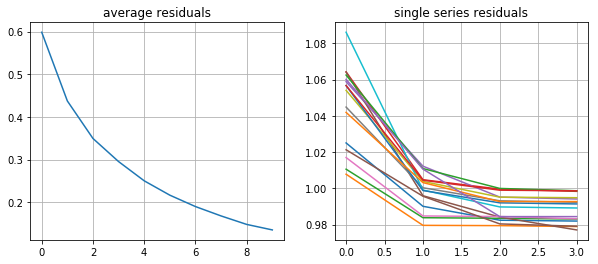

In [15]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
figure(figsize=[10,4]); subplot(121)
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals)
plot(1-cumvar[:10]); grid(); title('average residuals')
subplot(122)
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
for i in range(16):
    target=T[i,:]
    eigen_decomp=Eigen_decomp(None,target,Mean,v)
    total_var,residuals,reductions,_coeff=eigen_decomp.compute_var_explained()
    plot(list(residuals[1])); 
grid(); title('single series residuals');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [16]:
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
import numpy as np
from ipywidgets import interactive,widgets
from recon_plot import recon_plot

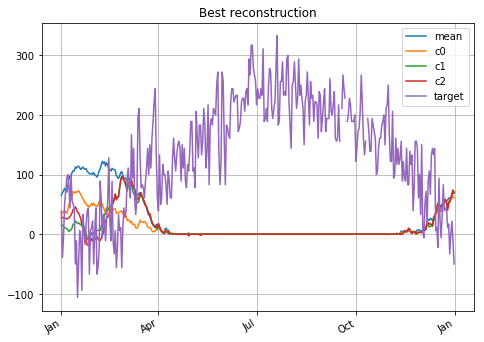

In [17]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

In [18]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%(m)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'


AnalysisException: u'Table or view not found: weather; line 1 pos 14'

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [19]:
def decompose(row):
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)  

In [20]:
#import numpy
rdd2=df1.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
df2.select('res_mean','res_1','res_2','res_3','total_var','coeff_1','coeff_2','coeff_3').show(3)

+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|total_var|           coeff_1|           coeff_2|           coeff_3|
+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+
| 2.209955432620985| 1.046814308319828|0.9581280375380435|0.8865782778918574| 298128.0|-598.3249940170076|161.76994189194897|-145.3588245004226|
| 2.284385322885889| 1.072236833604479|0.7114781562741938|0.6649519657554572| 218884.0|-616.0433321092116|233.20845084642053| -133.766535334883|
|1.7073099575975323|0.6619932455988242|0.6561226743917165|0.6141369472697049| 404427.0|-671.8168941500662|-41.12668707493687|105.69721009416432|
+------------------+------------------+------------------+------------------+---------+------------------+------------------+-----

In [79]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(None,target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter


In [59]:
row,=df2.take(1)

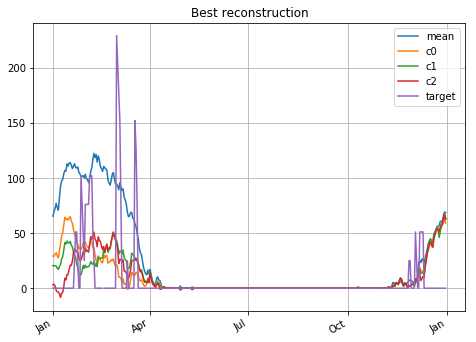

In [60]:
plotter=plot_decomp(row,Mean,v,interactive=True);
display(plotter.get_Interactive());

In [61]:
print 'before filter',df2.count()
df3=df2.filter(df2.total_var!=0)
print 'after filter',df3.count()

before filter 1321
after filter 1306


In [62]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)
df3.select('res_3').show(12)

+--------------------+
|               res_3|
+--------------------+
|  0.0319267930626137|
|  0.0330024968075879|
| 0.03310388652160637|
| 0.03454232269217832|
| 0.03670647176887014|
|0.041355884995479666|
|0.043604476552357656|
|0.043996326207136636|
|0.044268462771583715|
|0.047291261283064094|
| 0.05053228373189725|
| 0.05234549560501003|
+--------------------+
only showing top 12 rows



In [88]:
# %load lib/recon_plot.py
import numpy as np
from YearPlotter import YearPlotter
from Eigen_decomp import Eigen_decomp
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

class recon_plot:
    """A class for creating an interactive demonstration of approximating 
    a function with an orthonormal set of function"""
    def __init__(self,eigen_decomp,year_axis=False,fig=None,ax=None,interactive=False,Title=None,figsize=(6,4)):
        """ 
        Initialize the plot widget
        :param: eigen_decomp: An Eigen_Decomp object
        :param: year_axis: set to true if X axis should correspond to the months of the year.

        """
        self.eigen_decomp=eigen_decomp
        self.interactive=interactive
        self.fig=fig
        self.ax=ax
        self.Title=Title
        self.figsize=figsize
        self.i=0
        
        self.year_axis=year_axis
        self.yearPlotter=None
        if year_axis:
            self.yearPlotter=YearPlotter()
        if not self.interactive:
            self.plot_combination(**self.eigen_decomp.coeff)

        return None

    def get_Interactive(self):
        widge_list,widge_dict = self.get_widgets()
        w=interactive(self.plot_combination, **widge_dict);
        self.Title='Best reconstruction'
        self.plot_combination(**self.eigen_decomp.coeff)
        self.Title='Interactive reconstruction'
        return widgets.VBox([widgets.HBox(widge_list),w.children[-1]])

    def get_widgets(self):
        """return the slider widget that are to be used

        :returns: widget_list: the list of widgets in order
                  widget_dict: a dictionary of the widget to be used in `interact

        :todo: make the sliders smaller: http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
        """
        coeff=self.eigen_decomp.C
        widge_dict={}
        widge_list=[]
        for i in range(self.eigen_decomp.n):
            if coeff[i]>0:
                r=[0,coeff[i]*2]
            else:
                r=[coeff[i]*2,0]

            widge_list.append(widgets.FloatSlider(min=r[0],max=r[1],step=(r[1]-r[0])/10.,\
                                                  value=coeff[i],orientation='vertical',decription='v'+str(i)))
            widge_dict['c'+str(i)]=widge_list[-1]

        return widge_list,widge_dict

    def plot(self,y,label=''):
        print self.ax
        self.ax.plot([np.random.rand(5)])
        #if self.year_axis:
        #    self.yearPlotter.plot(y,self.fig,self.ax,label=label)
        #else:
        #    self.ax.plot(self.eigen_decomp.x,y,label=label);

    def plot_combination(self,**coeff):
        """the plotting function that is called by `interactive`
           generates the plot according the the parameters set by the sliders

        :returns: None
        """
        
        #print self.i,coeff
        #self.i+=1
        #return None
        
        if self.interactive or self.fig is None:
            self.fig=plt.figure(figsize=self.figsize)
            self.ax=self.fig.add_axes([0,0,1,1])

        A=self.eigen_decomp.mean
        self.plot(A,label='mean')

        for i in range(self.eigen_decomp.n):
            g=self.eigen_decomp.v[i]*coeff['c'+str(i)]
            A=A+g
            self.plot(A,label='c'+str(i))
        self.plot(self.eigen_decomp.f,label='target')
        self.ax.grid(figure=self.fig)        
        self.ax.legend()
        self.ax.set_title(self.Title)
        plt.show()
        return None
    

<class 'pyspark.sql.types.Row'>
Axes(0.125,0.657941;0.168478x0.222059)
Axes(0.125,0.657941;0.168478x0.222059)
Axes(0.125,0.657941;0.168478x0.222059)
Axes(0.125,0.657941;0.168478x0.222059)
Axes(0.125,0.657941;0.168478x0.222059)


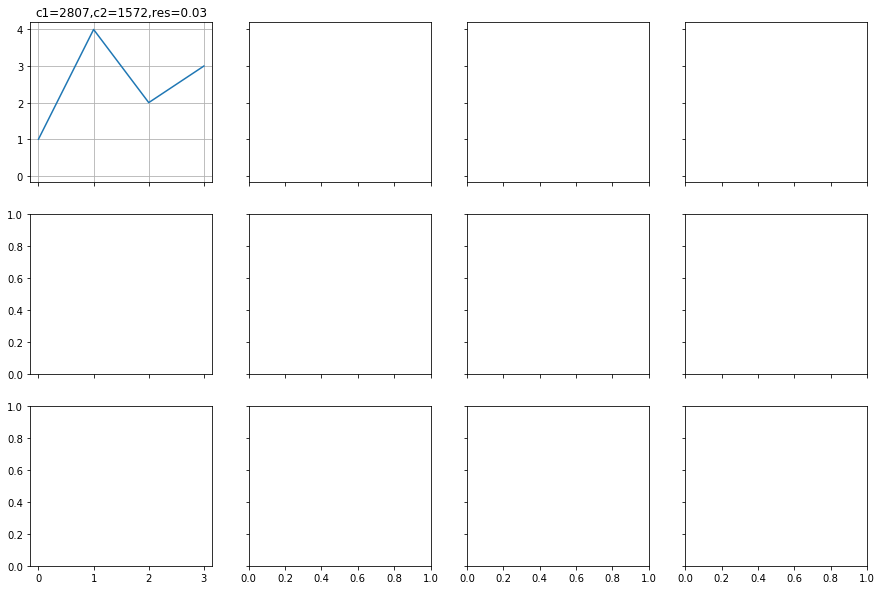

<class 'pyspark.sql.types.Row'>
Axes(0.327174,0.657941;0.168478x0.222059)
Axes(0.327174,0.657941;0.168478x0.222059)
Axes(0.327174,0.657941;0.168478x0.222059)
Axes(0.327174,0.657941;0.168478x0.222059)
Axes(0.327174,0.657941;0.168478x0.222059)
<class 'pyspark.sql.types.Row'>
Axes(0.529348,0.657941;0.168478x0.222059)
Axes(0.529348,0.657941;0.168478x0.222059)
Axes(0.529348,0.657941;0.168478x0.222059)
Axes(0.529348,0.657941;0.168478x0.222059)
Axes(0.529348,0.657941;0.168478x0.222059)
<class 'pyspark.sql.types.Row'>
Axes(0.731522,0.657941;0.168478x0.222059)
Axes(0.731522,0.657941;0.168478x0.222059)
Axes(0.731522,0.657941;0.168478x0.222059)
Axes(0.731522,0.657941;0.168478x0.222059)
Axes(0.731522,0.657941;0.168478x0.222059)
<class 'pyspark.sql.types.Row'>
Axes(0.125,0.391471;0.168478x0.222059)
Axes(0.125,0.391471;0.168478x0.222059)
Axes(0.125,0.391471;0.168478x0.222059)
Axes(0.125,0.391471;0.168478x0.222059)
Axes(0.125,0.391471;0.168478x0.222059)
<class 'pyspark.sql.types.Row'>
Axes(0.327174,0

In [89]:
#def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
column_n=4; row_n=3; figsize=(15,10)
fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        print type(row)
        k+=1
        _title='c1=%3.0f,c2=%3.0f,res=%3.2f'%(row['coeff_1'],row['coeff_2'],row['res_3'])
        plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)

In [85]:
np.random.rand(5)

array([ 0.9763317 ,  0.83591259,  0.01215998,  0.47278979,  0.3539808 ])

c1=2807,c2=1572,res=0.03
Axes(0.125,0.657941;0.168478x0.222059)
Axes(0.125,0.68;0.168478x0.2)
Axes(0.125,0.68;0.168478x0.2)
Axes(0.125,0.68;0.168478x0.2)
Axes(0.125,0.68;0.168478x0.2)


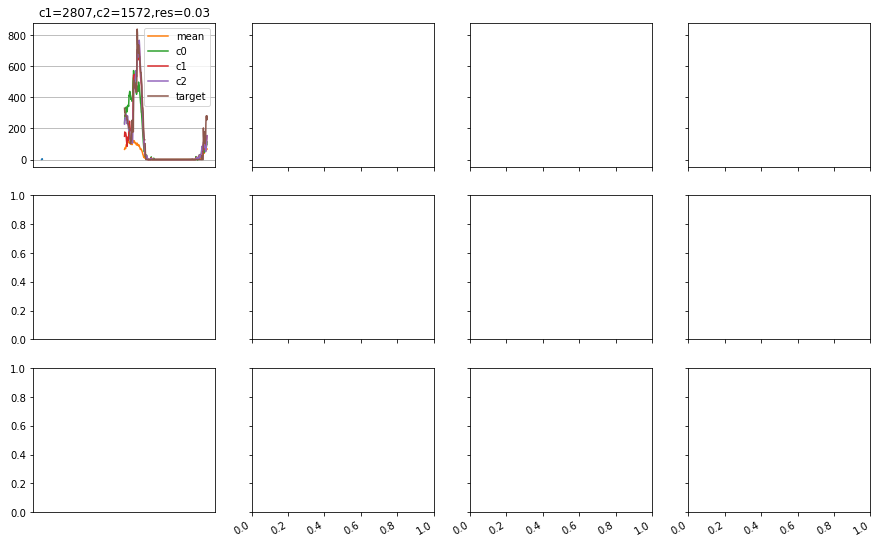

c1=2029,c2=-1539,res=0.03
Axes(0.327174,0.68;0.168478x0.2)
Axes(0.327174,0.68;0.168478x0.2)
Axes(0.327174,0.68;0.168478x0.2)
Axes(0.327174,0.68;0.168478x0.2)
Axes(0.327174,0.68;0.168478x0.2)
c1=3004,c2= 60,res=0.03
Axes(0.529348,0.68;0.168478x0.2)
Axes(0.529348,0.68;0.168478x0.2)
Axes(0.529348,0.68;0.168478x0.2)
Axes(0.529348,0.68;0.168478x0.2)
Axes(0.529348,0.68;0.168478x0.2)
c1=3445,c2=-334,res=0.03
Axes(0.731522,0.68;0.168478x0.2)
Axes(0.731522,0.68;0.168478x0.2)
Axes(0.731522,0.68;0.168478x0.2)
Axes(0.731522,0.68;0.168478x0.2)
Axes(0.731522,0.68;0.168478x0.2)
c1=2489,c2=2484,res=0.04
Axes(0.125,0.44;0.168478x0.2)
Axes(0.125,0.44;0.168478x0.2)
Axes(0.125,0.44;0.168478x0.2)
Axes(0.125,0.44;0.168478x0.2)
Axes(0.125,0.44;0.168478x0.2)
c1=1120,c2=-1297,res=0.04
Axes(0.327174,0.44;0.168478x0.2)
Axes(0.327174,0.44;0.168478x0.2)
Axes(0.327174,0.44;0.168478x0.2)
Axes(0.327174,0.44;0.168478x0.2)
Axes(0.327174,0.44;0.168478x0.2)
c1=3235,c2=-2461,res=0.04
Axes(0.529348,0.44;0.168478x0.2)
Axes(

In [80]:
plot_recon_grid(rows)

c1=-854,c2=150,res=22.91


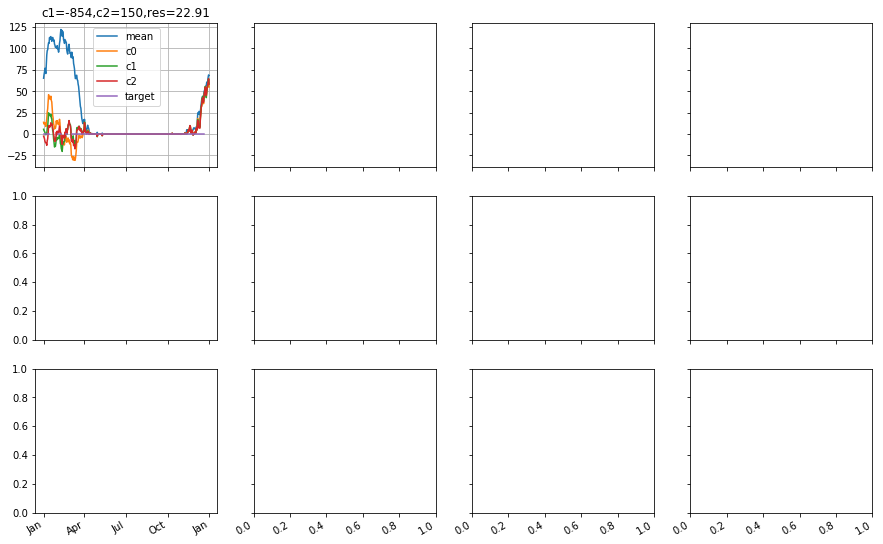

c1=-846,c2=144,res=14.44
c1=-828,c2=129,res=7.17
c1=-835,c2=135,res=6.58
c1=-850,c2=149,res=5.38
c1=-802,c2=163,res=3.92
c1=-819,c2=140,res=3.19
c1=-819,c2=103,res=2.91
c1=-795,c2=130,res=2.85
c1=-824,c2=143,res=2.72
c1=-832,c2=128,res=2.60
c1=-812,c2= 99,res=2.55


In [44]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [ ]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]

len(R3)

In [ ]:
plot(R3)
title('distribution of residuals')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [ ]:
print df3.count(),
df4=df3.filter(df3.res_3<0.5)
print '->',df4.count()

In [ ]:
c=df4.select('coeff_1').collect()
c1=[x['coeff_1'] for x in c]
c=df4.select('coeff_2').collect()
c2=[x['coeff_2'] for x in c]
c1[:4],c2[:4]

In [ ]:
figure(figsize=(8,8))
scatter(c1,c2,marker='.')
xlabel('coeff 1')
ylabel('coeff 2')
grid()

In [ ]:
df3.write.parquet(data_dir+'/decon_'+file_index+'.parquet')

In [ ]:
data_dir

In [ ]:
!ls -lrt $data_dir

In [ ]:
!du -sh $data_dir/*